# Red de pases en fútbol con datos de StatsBomb
Este cuaderno construye y visualiza una red de pases de un equipo a partir de los datos abiertos de StatsBomb usando NetworkX y Matplotlib.

In [1]:
# 🔧 Instalar librerías necesarias
# !pip install pandas numpy matplotlib networkx statsbombpy

In [38]:
# 📥 Cargar datos de StatsBomb
from statsbombpy import sb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Cargar partidos y eventos del Mundial Femenino 2019
matches = sb.matches(competition_id=72, season_id=30)
match_id = matches.iloc[0]['match_id']
events = sb.events(match_id=match_id)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [19]:
# Filtrar solo pases completados del equipo local
team_name = events[events['team'] == events.iloc[0]['team']]['team'].iloc[0]
passes = events[(events['type'] == 'Pass') & (events['pass_outcome'].isnull()) & (events['team'] == team_name)].copy()

In [35]:
# ⚙️ Calcular posición promedio y pases entre jugadores
passes['x'] = passes['location'].apply(lambda x: x[0])
passes['y'] = passes['location'].apply(lambda x: x[1])

# Posiciones promedio por jugador
avg_positions = passes.groupby('player')[['x', 'y']].mean()

# Conteo de pases entre jugadores
pass_counts = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='count')
pass_counts = pass_counts[pass_counts['pass_recipient'].notnull()]


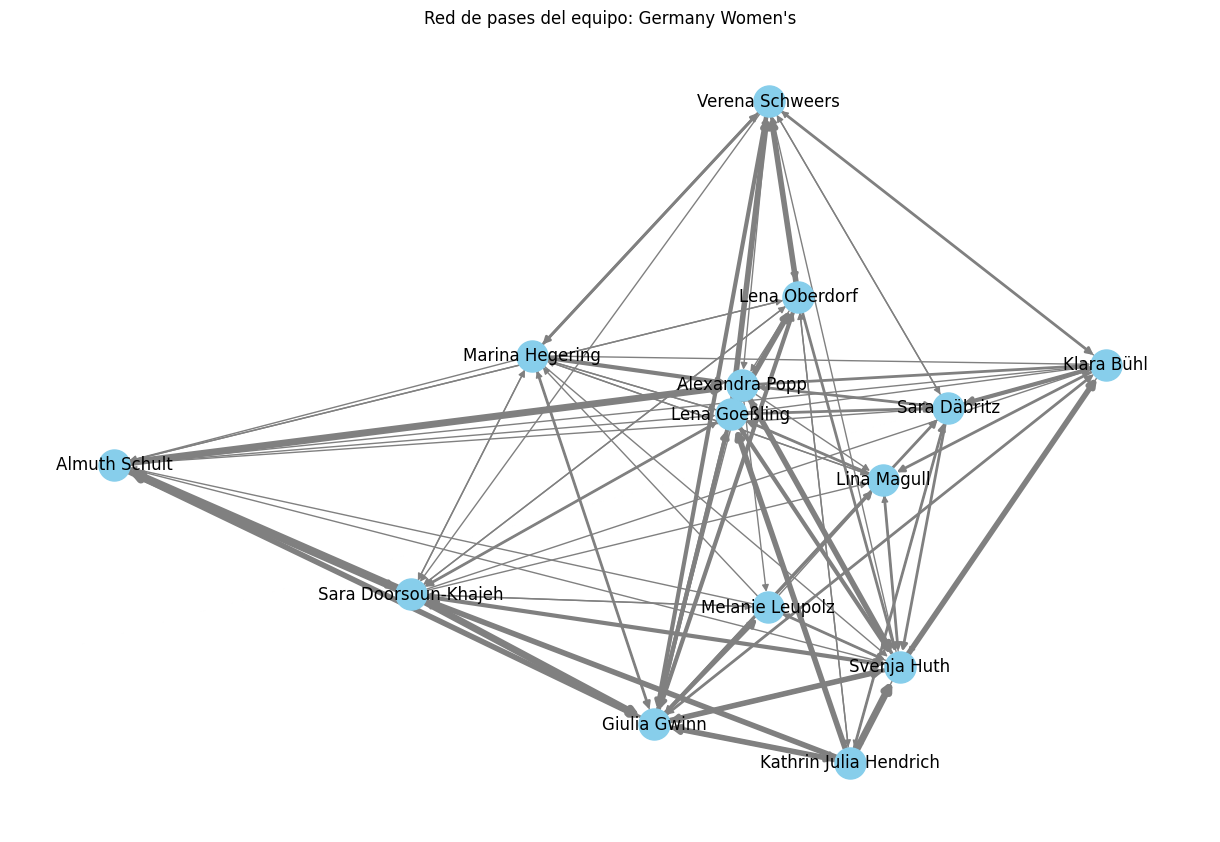

In [40]:
# 📊 Visualizar red de pases

# Crear grafo
G = nx.DiGraph()

# Añadir nodos con posiciones
for player, pos in avg_positions.iterrows():
    G.add_node(player, pos=(pos['x'], pos['y']))

# Añadir aristas con peso
for _, row in pass_counts.iterrows():
    G.add_edge(row['player'], row['pass_recipient'], weight=row['count'])

# Dibujar grafo
plt.figure(figsize=(12, 8))
pos = nx.get_node_attributes(G, 'pos')
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', width=weights, arrows=True)
plt.title(f'Red de pases del equipo: {team_name}')
plt.gca().invert_yaxis()
plt.show()

In [45]:
# 📈 Métricas de centralidad (continuación)
centrality_df = pd.DataFrame({
    'Jugador': list(nx.degree_centrality(G).keys()),
    'Centralidad de grado': list(nx.degree_centrality(G).values()),
    'Centralidad de intermediación': list(nx.betweenness_centrality(G).values()),
    'Centralidad de eigenvector': list(nx.eigenvector_centrality(G).values())
})

# Mostrar los 10 jugadores más influyentes
centrality_df.sort_values(by='Centralidad de eigenvector', ascending=False).head(10)


,Jugador,Centralidad de grado,Centralidad de intermediación,Centralidad de eigenvector
12,Svenja Huth,1.615385,0.081496,0.381490
2,Giulia Gwinn,1.769231,0.099050,0.366322
4,Klara Bühl,1.076923,0.012447,0.314695
5,Lena Goeßling,1.384615,0.041461,0.307915
7,Lina Magull,0.923077,0.008929,0.297506
10,Sara Doorsoun-Khajeh,1.461538,0.062511,0.288608
13,Verena Schweers,1.153846,0.032798,0.264395
8,Marina Hegering,1.230769,0.044588,0.248131
0,Alexandra Popp,1.076923,0.029153,0.233123
11,Sara Däbritz,1.000000,0.020566,0.231334
